**Introduction: Store-Level Demand Exploration**

Reliable demand forecasts are the backbone of every retail decision—how much inventory to hold, when to replenish, how to staff stores, and which promotions to run. This project walks through a fully reproducible, code-first exploratory data analysis (EDA) of a real-world retail dataset (StoreDemand.csv) that contains three years of daily sales for a single SKU recorded at four different stores.

Instead of a dry slide deck, we treat the notebook itself as the deliverable: every insight is generated live with pandas, Seaborn, Plotly, and statsmodels.

You will see how to:

1. Clean and enrich raw transactional logs with time-based features (day-of-week, holidays, calendar heat-maps).
2. Detect seasonality, trend, and outliers at both global and store-specific levels.
3. Quantify cross-store heterogeneity—some locations routinely outsell others by 3×, but the peak days are not always aligned.
4. Build quick visual diagnostics (lag plots, ACF) that tell you whether the series is forecast-ready or needs pre-processing.

The end-state is not a final forecasting model; it is a trustworthy baseline understanding of the data that any subsequent ML or statistical forecaster can stand on.

Clone the notebook, swap in your own SKU or geography, and the same cells adapt automatically—giving you a reusable EDA template for retail demand in under 15 minutes.

**0. Setup & Data Ingestion**

In [1]:
# !pip install -q pandas numpy matplotlib seaborn plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import warnings, itertools
warnings.filterwarnings('ignore')

# 1.  Read data
df = pd.read_csv('/content/sample_data/StoreDemand.csv', parse_dates=['date'])

# 2.  Quick sanity checks
display(df.head())
print(df.shape, df.dtypes, df.isna().sum(), sep='\n')

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


(913000, 4)
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object
date     0
store    0
item     0
sales    0
dtype: int64


**1. Basic Data Overview**

In [2]:
# 1.1  Unique values per categorical column
for col in ['store','item']:
    print(f'{col:>5}: {df[col].nunique()} unique → {sorted(df[col].unique())}')

# 1.2  Numeric summary
display(df.describe().T)

# 1.3  Duplicate rows?
print('Duplicated rows:', df.duplicated().sum())

store: 10 unique → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
 item: 50 unique → [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50)]


,count,mean,min,25%,50%,75%,max,std
date,913000,2015-07-02 11:59:59.999999744,2013-01-01 00:00:00,2014-04-02 00:00:00,2015-07-02 12:00:00,2016-10-01 00:00:00,2017-12-31 00:00:00,NaN
store,913000.0,5.5,1.0,3.0,5.5,8.0,10.0,2.872283
item,913000.0,25.5,1.0,13.0,25.5,38.0,50.0,14.430878
sales,913000.0,52.250287,0.0,30.0,47.0,70.0,231.0,28.801144


Duplicated rows: 0


**2. Parse & Enrich Time Features**

In [3]:
# 2.1  Build a full calendar to spot missing days
cal = pd.date_range(df.date.min(), df.date.max(), freq='D')
print('Calendar range :', cal[0], '→', cal[-1])
print('Actual  range  :', df.date.min(), '→', df.date.max())
print('Missing dates  :', len(cal) - df.date.nunique())

# 2.2  Add human-readable time features
df = (df
      .assign(year=df.date.dt.year,
              month=df.date.dt.month,
              day=df.date.dt.day,
              dow=df.date.dt.day_name(),
              woy=df.date.dt.isocalendar().week)
)

# 2.3  Preview
df.head()

Calendar range : 2013-01-01 00:00:00 → 2017-12-31 00:00:00
Actual  range  : 2013-01-01 00:00:00 → 2017-12-31 00:00:00
Missing dates  : 0


,date,store,item,sales,year,month,day,dow,woy
0,2013-01-01,1,1,13,2013,1,1,Tuesday,1
1,2013-01-02,1,1,11,2013,1,2,Wednesday,1
2,2013-01-03,1,1,14,2013,1,3,Thursday,1
3,2013-01-04,1,1,13,2013,1,4,Friday,1
4,2013-01-05,1,1,10,2013,1,5,Saturday,1


**3. Global Sales Distribution**

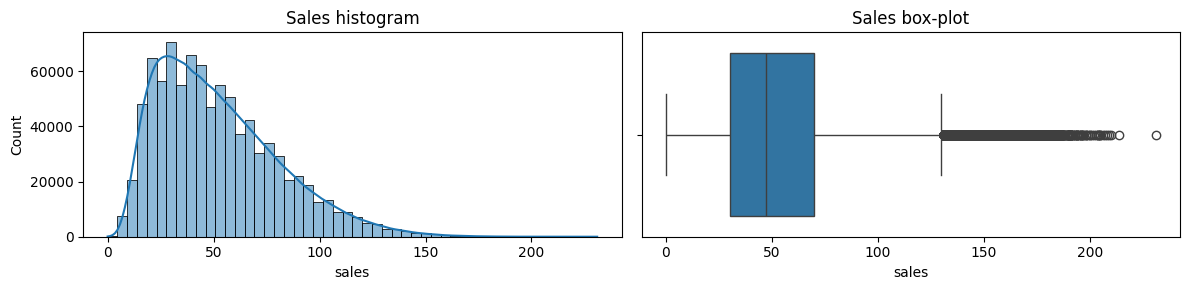

Top-5 sales days:
              date  store  sales
259109 2017-07-02      2    231
386579 2016-07-17      2    214
222596 2017-07-09      2    210
258759 2016-07-17      2    209
313889 2017-07-02      2    208


In [4]:
plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
sns.histplot(df.sales, bins=50, kde=True)
plt.title('Sales histogram')

plt.subplot(1,2,2)
sns.boxplot(x=df.sales)
plt.title('Sales box-plot')

plt.tight_layout()
plt.show()

# Optional: check extreme values
print('Top-5 sales days:\n', df.nlargest(5, 'sales')[['date','store','sales']])

**4. Sales Through Time**

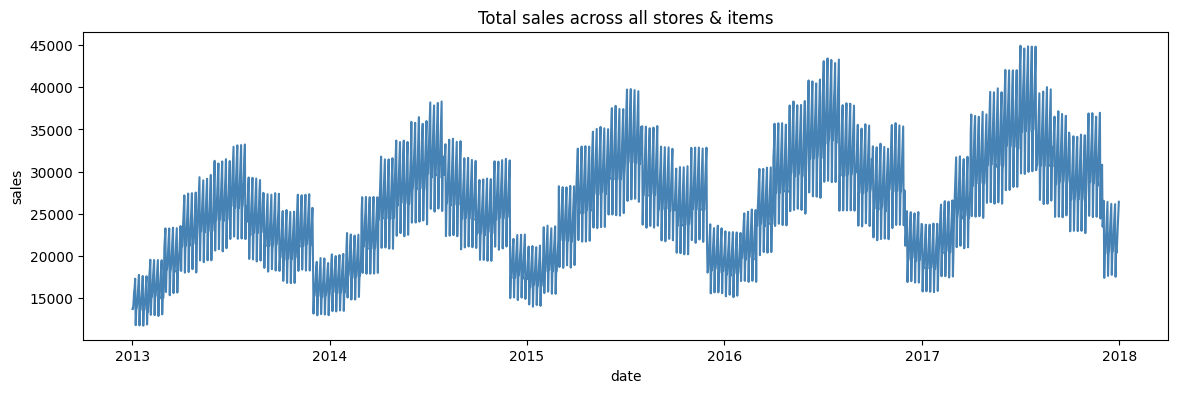

In [5]:
daily = df.groupby('date').sales.sum().reset_index()

plt.figure(figsize=(14,4))
sns.lineplot(data=daily, x='date', y='sales', color='steelblue')
plt.title('Total sales across all stores & items')
plt.show()

# Interactive zoom-able version
px.line(daily, x='date', y='sales', title='Interactive daily sales').show()

**5. Seasonality Check**

TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x7e86b01b8d40>.

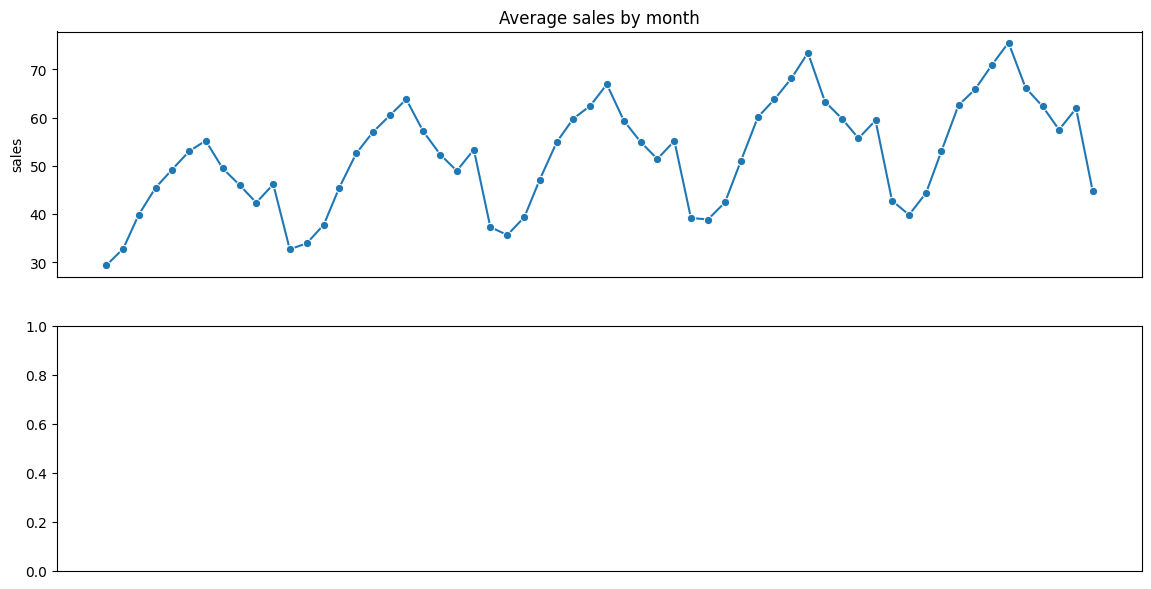

In [16]:
fig, ax = plt.subplots(2,1, figsize=(14,7), sharex=True)

# 5.1  Monthly pattern
monthly = df.groupby(['year','month']).sales.mean().reset_index()
monthly['year-month'] = pd.to_datetime(monthly[['year','month']].assign(day=1))
sns.lineplot(data=monthly, x='year-month', y='sales', ax=ax[0], marker='o')
ax[0].set_title('Average sales by month')

# 5.2  Day-of-week pattern
dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dow = df.groupby('dow').sales.mean().reindex(dow_order)
# sns.barplot(x=dow.index, y=dow.values, ax=ax[1], palette='Blues_d')
sns.boxplot(x='dow', y='sales', data=df, order=dow_order, ax=ax[1])
ax[1].set_title('Average sales by day-of-week')
ax[1].set_ylabel('Sales')

plt.tight_layout()
plt.show()

**6. Store-Level Comparison**

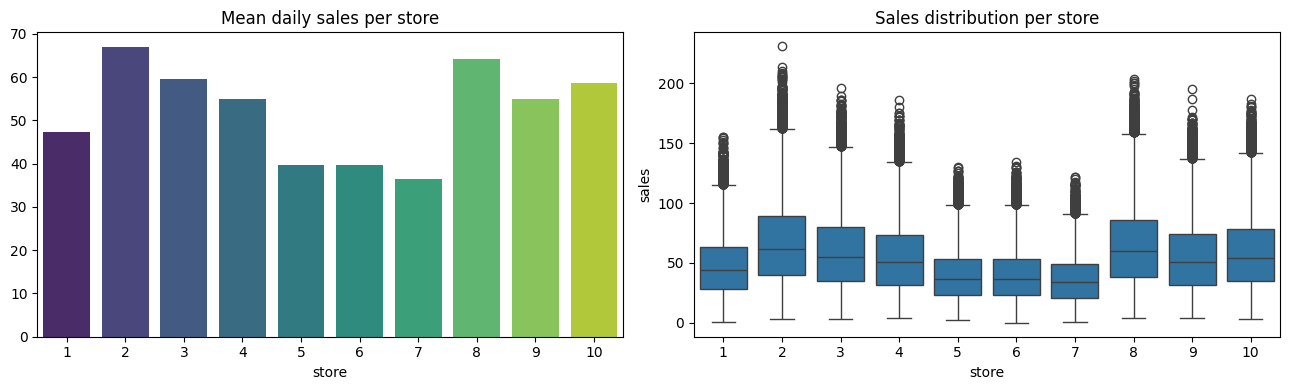

In [7]:
plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
store_avg = df.groupby('store').sales.mean()
sns.barplot(x=store_avg.index, y=store_avg.values, palette='viridis')
plt.title('Mean daily sales per store')

plt.subplot(1,2,2)
sns.boxplot(x='store', y='sales', data=df)
plt.title('Sales distribution per store')

plt.tight_layout()
plt.show()

**7. Correlation with External Factors (simple)**

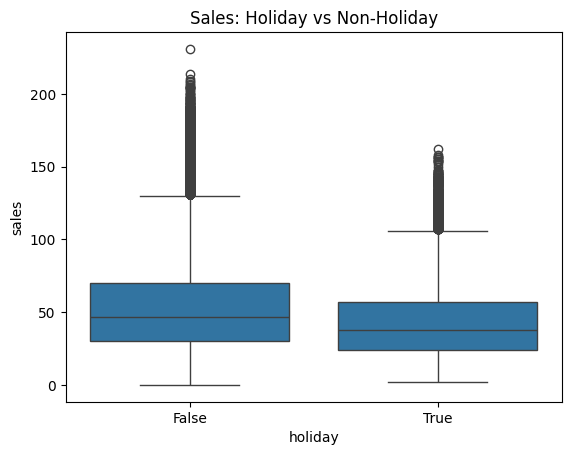

In [8]:
# 7.1  Create a dummy "holiday" flag (US Federal holidays approx.)
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df.date.min(), end=df.date.max())
df['holiday'] = df.date.isin(holidays)

# 7.2  Compare sales
sns.boxplot(x='holiday', y='sales', data=df)
plt.title('Sales: Holiday vs Non-Holiday')
plt.show()

**8. Lag & Autocorrelation (Time-series flavour)**

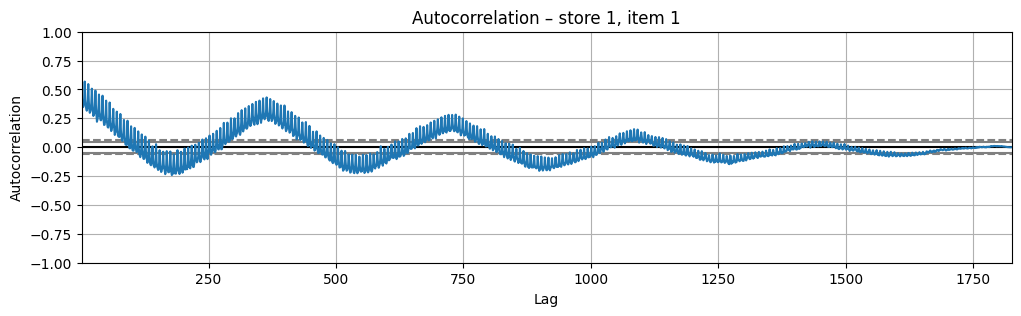

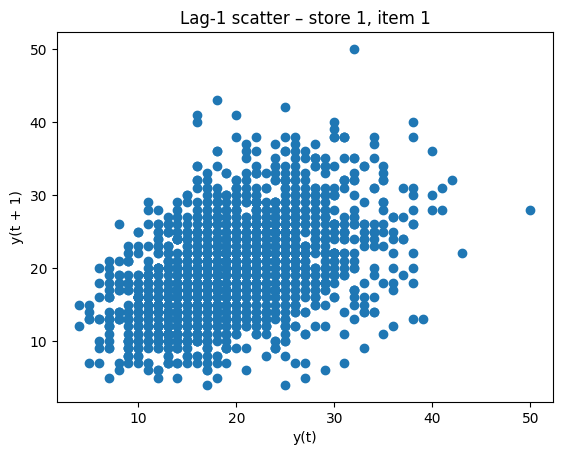

In [9]:
from pandas.plotting import autocorrelation_plot

# 8.1  Single-series (store 1, item 1) for demo
ts = df.query('store==1 & item==1').set_index('date').sales.sort_index()

plt.figure(figsize=(12,3))
autocorrelation_plot(ts)
plt.title('Autocorrelation – store 1, item 1')
plt.show()

# 8.2  Lag scatter
pd.plotting.lag_plot(ts, lag=1)
plt.title('Lag-1 scatter – store 1, item 1')
plt.show()

**9. Heat-map: Daily Sales Calendar**

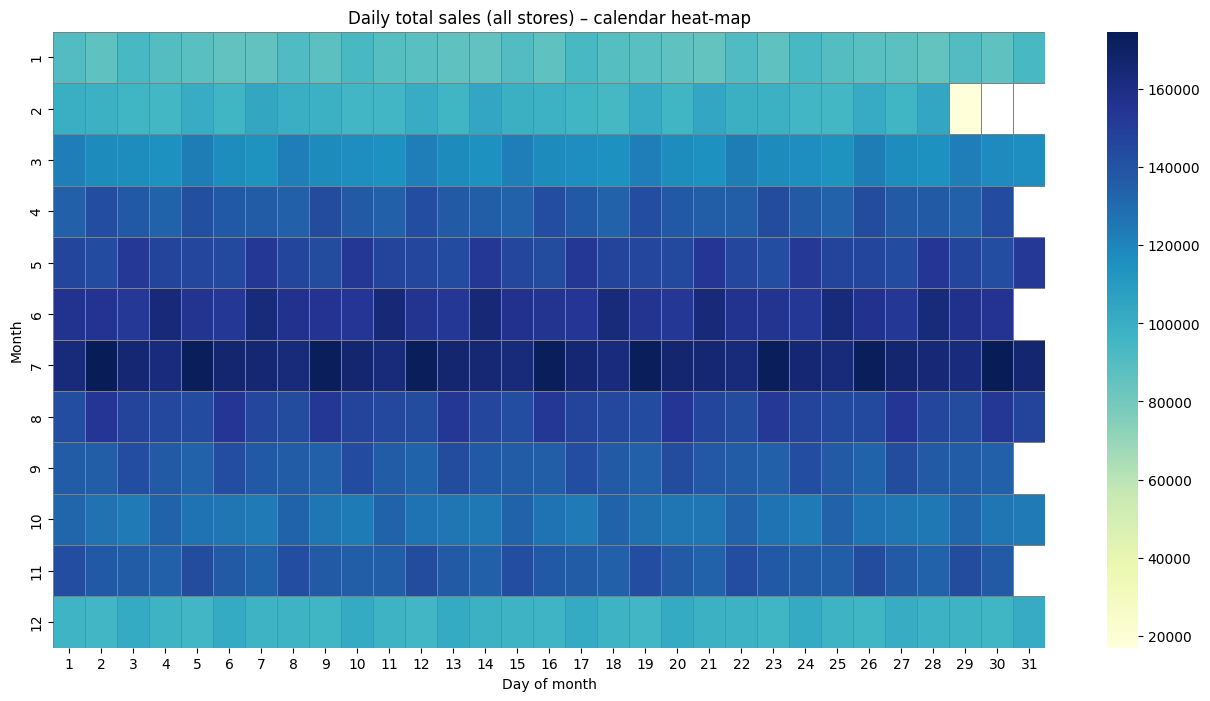

In [10]:
# 9.1  Pivot to calendar shape
cal_map = (df.assign(d=df.date.dt.day, m=df.date.dt.month)
             .pivot_table(values='sales', index='m', columns='d', aggfunc='sum'))

plt.figure(figsize=(16,8))
sns.heatmap(cal_map, cmap='YlGnBu', linewidths=.5, linecolor='gray')
plt.title('Daily total sales (all stores) – calendar heat-map')
plt.ylabel('Month'); plt.xlabel('Day of month')
plt.show()

**10. Quick Outlier Detection**

In [11]:
# 10.1  IQR method per store
def iqr_bounds(series, k=1.5):
    q1, q3 = series.quantile([.25,.75])
    iqr = q3-q1
    return q1 - k*iqr, q3 + k*iqr

out = []
for s in df.store.unique():
    lo, hi = iqr_bounds(df.loc[df.store==s, 'sales'])
    out.append(df.query('store==@s & (sales<@lo | sales>@hi)'))

outliers = pd.concat(out)
print(f'Found {len(outliers)} IQR outliers')
display(outliers.head())

Found 4845 IQR outliers


,date,store,item,sales,year,month,day,dow,woy,holiday
129057,2016-05-22,1,8,116,2016,5,22,Sunday,20,False
129078,2016-06-12,1,8,121,2016,6,12,Sunday,23,False
129085,2016-06-19,1,8,120,2016,6,19,Sunday,24,False
129111,2016-07-15,1,8,117,2016,7,15,Friday,28,False
129113,2016-07-17,1,8,120,2016,7,17,Sunday,28,False
